In [1]:
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from scipy.stats import linregress

from bamf.bamfCR import *

import time

from sklearn.model_selection import KFold

np.random.seed(123)

# set plot parameters
params = {'legend.fontsize': 18,
          'figure.figsize': (8, 7),
          'axes.labelsize': 24,
          'axes.titlesize':24,
          'axes.linewidth':3,
          'xtick.labelsize':20,
          'ytick.labelsize':20}
plt.rcParams.update(params)
plt.style.use('seaborn-colorblind')
plt.rcParams['pdf.fonttype'] = 42

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Import data

In [2]:
# used later for model validation
gLV_data = pd.read_csv("gLV_data/DSM_processed_mono.csv")
gLV_data.head()

,Treatments,Time,CA,BT,BU,CS,CD,DP,CH,BV
0,DSM27147-BT,0.0,0.000000,0.005000,0.000000,0.0,0.005000,0.0,0.0,0.000000
1,DSM27147-BT,12.0,0.000000,1.309089,0.000000,0.0,0.219745,0.0,0.0,0.000000
2,DSM27147-BT,24.0,0.000000,1.069737,0.000000,0.0,0.109763,0.0,0.0,0.000000
3,DSM27147-BT-BU-BV-CA,0.0,0.002000,0.002000,0.002000,0.0,0.002000,0.0,0.0,0.002000
4,DSM27147-BT-BU-BV-CA,12.0,0.010216,1.074319,0.070321,0.0,0.287990,0.0,0.0,0.119654


In [3]:
# get species names
species = list(gLV_data.columns.values[2:])

# Define function to make predictions on test data

In [4]:
# Define function to make predictions on test data

def test(model, df_test):
    all_treatments = df_test.Treatments.values
    unique_treatments = np.unique(all_treatments)
    numspecies = len(species)
    
    # save true values and predictions
    true = []
    pred = []
    stdv = []
    spcs = []

    # pull a random community trajectory
    for treatment in unique_treatments:
        comm_inds = np.in1d(df_test['Treatments'].values, treatment)
        comm_data = df_test.iloc[comm_inds].copy()

        # make sure comm_data is sorted in chronological order
        comm_data.sort_values(by='Time', ascending=True, inplace=True)
        tspan = comm_data.Time.values

        # pull just the community data
        output_true = comm_data[species].values

        # run model using parameters
        x_test = np.copy(output_true[0, :])
        
        # predict end-point measured values
        output, output_stdv, _ = model.predict_latent(x_test, tspan)
        true.append(output_true[-1])
        pred.append(output[-1, :len(species)])
        stdv.append(output_stdv[-1, :len(species)])
        spcs.append(species)
        
    return np.concatenate(true), np.concatenate(pred), np.concatenate(stdv), np.concatenate(spcs)

# Initialize model parameters

In [5]:
# global parameters 
n_s = len(species)
n_r = 3

# death rate 
d = -3.*np.ones(n_s)

# resource carrying capacity
Kr = np.ones(n_r)

# maximum consumption rate parameters
C = -5.*np.ones([n_r, n_s])
C[0] = -1.

# maximum production rate parameters
P = -5.*np.ones([n_r, n_s])

# efficiency of species / attractiveness of resources
f = np.ones(n_s)

# concatenate parameters 
params = np.concatenate((d, C.flatten(), f))#, P.flatten(), Kr))

# concatenate prior 
Cprior = -5.*np.ones([n_r, n_s])
Pprior = -5.*np.ones([n_r, n_s])
prior = np.concatenate((d, Cprior.flatten(), f))#, Pprior.flatten(), Kr))

n_params = len(params)
n_params

40

In [6]:
C.T

array([[-1., -5., -5.],
       [-1., -5., -5.],
       [-1., -5., -5.],
       [-1., -5., -5.],
       [-1., -5., -5.],
       [-1., -5., -5.],
       [-1., -5., -5.],
       [-1., -5., -5.]])

# Define model

In [7]:
# using consumer resource model  
def system(t, x, params): 
    
    # species 
    s = x[:n_s]
    
    # resources
    r = jnp.exp(x[n_s:])
    
    # death rate
    d = jnp.exp(params[:n_s])
    
    # consumption rate parameters
    C = jnp.exp(np.reshape(params[n_s:n_s+n_r*n_s], [n_r, n_s]))
    
    # efficiency of species
    f = jax.nn.sigmoid(params[n_s+n_r*n_s:n_s+n_r*n_s+n_s])
    
    # production rate parameters
    # P = jnp.exp(np.reshape(params[n_s+n_r*n_s+n_s:n_s+n_r*n_s+n_s+n_r*n_s], [n_r, n_s]))
    # resource carrying capacity 
    # Kr = jnp.exp(params[n_s+n_r*n_s+n_s+n_r*n_s:])
    
    # rate of change of species 
    dsdt = s*(f*(C.T@r) - d) 

    # rate of change of log of resources 
    dlrdt = -C@s # + (P@s)*(1. - r/Kr) 

    return jnp.append(dsdt, dlrdt)

# Define observation matrix

In [8]:
# define observation matrices 
O = np.zeros([n_s, n_s+n_r])
O[:n_s,:n_s] = np.eye(n_s)
O

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])

# K-fold cross-validation

In [9]:
# split dataframes according to treatment name 
dfs = [df for name, df in gLV_data.groupby("Treatments")]

# set up Kfold object 
kf = KFold(n_splits = 5)

In [10]:
r0 = np.random.uniform(-3, 0, n_r)
print(r0)

# save true values, test predictions and uncertainty to a dataframe
kfold_df = pd.DataFrame()

for train_ind, test_ind in kf.split(dfs):
    
    # pull train and test data
    train_data = pd.concat([dfs[ind] for ind in train_ind])
    test_data  = pd.concat([dfs[ind] for ind in test_ind])

    # fit model to training data
    model = ODE(system = system, 
                dataframe=train_data,
                C=O,
                CRparams = params, 
                r0 = r0,
                prior = prior,
                species = species,
                alpha_0 = 1e-5,
                f_ind = .7,
                verbose=True)

    # fit to data 
    t0 = time.time()
    model.fit(evidence_tol=1e-3, patience=1, max_fails=1)
    print("Elapsed time {:.2f}s".format(time.time()-t0))
    
    # test model 
    true, pred, stdv, spcs = test(model, test_data)
    
    # save results
    fold_df = pd.DataFrame()
    fold_df['True'] = true
    fold_df['Pred'] = pred
    fold_df['Stdv'] = stdv
    fold_df['Spcs'] = spcs
    kfold_df = pd.concat((kfold_df, fold_df))

[-0.91059244 -2.141582   -2.31944564]
Updating precision...
Total samples: 1490, Updated regularization: 1.00e-05
Total weighted fitting error: 24.519
Total weighted fitting error: 13.567
Total weighted fitting error: 7.769
Total weighted fitting error: 6.538
Total weighted fitting error: 5.101
Total weighted fitting error: 5.037
Total weighted fitting error: 4.920
Total weighted fitting error: 4.718
Total weighted fitting error: 4.440
Total weighted fitting error: 4.379
Total weighted fitting error: 4.296
Total weighted fitting error: 4.267
Total weighted fitting error: 4.265
Total weighted fitting error: 4.261
Total weighted fitting error: 4.261
Total weighted fitting error: 4.260
Total weighted fitting error: 4.259
Total weighted fitting error: 4.258
Total weighted fitting error: 4.257
Total weighted fitting error: 4.257
Total weighted fitting error: 4.257
Total weighted fitting error: 4.256
Total weighted fitting error: 4.256
Total weighted fitting error: 4.256
Total weighted fitti

Total weighted fitting error: 733.889
Total weighted fitting error: 733.832
Total weighted fitting error: 733.793
Total weighted fitting error: 733.733
Total weighted fitting error: 733.699
Total weighted fitting error: 733.694
Total weighted fitting error: 733.692
Total weighted fitting error: 733.690
Total weighted fitting error: 733.690
Total weighted fitting error: 733.690
 message: Warning: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 733.6896746607033
       x: [ 1.419e-01  2.096e-01 ... -1.129e+00  1.753e+00]
     nit: 10
     jac: [-1.030e-01  5.690e-02 ...  3.123e-02 -5.541e-02]
    nfev: 71
    njev: 61
    nhev: 11
Evidence 3496.955
Updating precision...
Total samples: 1490, Updated regularization: 6.02e-07
Total weighted fitting error: 736.283
Total weighted fitting error: 736.274
Total weighted fitting error: 736.268
Total weighted fitting error: 736.264
Total weighted fitting error: 736.261
Total weighted fitting erro

Total weighted fitting error: 612.748
Total weighted fitting error: 612.291
Total weighted fitting error: 611.479
Total weighted fitting error: 610.336
Total weighted fitting error: 609.687
Total weighted fitting error: 609.582
Total weighted fitting error: 609.520
Total weighted fitting error: 609.429
Total weighted fitting error: 609.423
Total weighted fitting error: 609.411
Total weighted fitting error: 609.393
Total weighted fitting error: 609.385
Total weighted fitting error: 609.383
Total weighted fitting error: 609.381
Total weighted fitting error: 609.379
Total weighted fitting error: 609.374
Total weighted fitting error: 609.370
Total weighted fitting error: 609.368
Total weighted fitting error: 609.362
Total weighted fitting error: 609.362
 message: Warning: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 609.3622703461748
       x: [ 1.677e-01  1.197e-01 ... -1.166e+00  1.533e+00]
     nit: 20
     jac: [-1.974e-02 -3.264e-

Total weighted fitting error: 2.751
Total weighted fitting error: 2.751
Total weighted fitting error: 2.751
Total weighted fitting error: 2.750
Total weighted fitting error: 2.748
Total weighted fitting error: 2.748
Total weighted fitting error: 2.748
Total weighted fitting error: 2.747
Total weighted fitting error: 2.747
Total weighted fitting error: 2.747
Total weighted fitting error: 2.747
Total weighted fitting error: 2.747
Total weighted fitting error: 2.746
Total weighted fitting error: 2.746
Total weighted fitting error: 2.746
Total weighted fitting error: 2.746
Total weighted fitting error: 2.746
Total weighted fitting error: 2.745
Total weighted fitting error: 2.745
Total weighted fitting error: 2.745
Total weighted fitting error: 2.745
Total weighted fitting error: 2.745
Total weighted fitting error: 2.745
Total weighted fitting error: 2.745
Total weighted fitting error: 2.744
Total weighted fitting error: 2.744
Total weighted fitting error: 2.744
Total weighted fitting error

Total weighted fitting error: 730.763
 message: Warning: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 730.7629606538447
       x: [ 5.966e-02  1.325e+00 ... -3.091e+00  2.288e+00]
     nit: 18
     jac: [-3.454e+00 -3.753e-01 ...  6.406e-02 -1.815e-01]
    nfev: 42
    njev: 30
    nhev: 19
Evidence 3608.483
Updating precision...
Total samples: 1501, Updated regularization: 6.04e-07
Total weighted fitting error: 740.948
Total weighted fitting error: 740.765
Total weighted fitting error: 740.601
Total weighted fitting error: 740.432
Total weighted fitting error: 740.406
Total weighted fitting error: 740.387
Total weighted fitting error: 740.375
Total weighted fitting error: 740.353
Total weighted fitting error: 740.313
Total weighted fitting error: 740.253
Total weighted fitting error: 740.244
Total weighted fitting error: 740.230
Total weighted fitting error: 740.212
Total weighted fitting error: 740.210
Total weighted fitting erro

Total weighted fitting error: 2.661
Total weighted fitting error: 2.633
Total weighted fitting error: 2.600
Total weighted fitting error: 2.598
Total weighted fitting error: 2.570
Total weighted fitting error: 2.531
Total weighted fitting error: 2.523
Total weighted fitting error: 2.506
Total weighted fitting error: 2.477
Total weighted fitting error: 2.465
Total weighted fitting error: 2.463
Total weighted fitting error: 2.459
Total weighted fitting error: 2.458
Total weighted fitting error: 2.444
Total weighted fitting error: 2.431
Total weighted fitting error: 2.428
Total weighted fitting error: 2.427
Total weighted fitting error: 2.424
Total weighted fitting error: 2.421
Total weighted fitting error: 2.420
Total weighted fitting error: 2.418
Total weighted fitting error: 2.414
Total weighted fitting error: 2.414
Total weighted fitting error: 2.413
Total weighted fitting error: 2.411
Total weighted fitting error: 2.411
Total weighted fitting error: 2.409
Total weighted fitting error

Total weighted fitting error: 739.859
Total weighted fitting error: 739.661
Total weighted fitting error: 739.440
Total weighted fitting error: 739.419
Total weighted fitting error: 739.255
Total weighted fitting error: 739.241
Total weighted fitting error: 739.217
Total weighted fitting error: 739.175
Total weighted fitting error: 739.154
Total weighted fitting error: 739.145
Total weighted fitting error: 739.134
Total weighted fitting error: 739.115
Total weighted fitting error: 739.114
Total weighted fitting error: 739.101
Total weighted fitting error: 739.099
Total weighted fitting error: 739.098
Total weighted fitting error: 739.088
Total weighted fitting error: 739.087
Total weighted fitting error: 739.076
Total weighted fitting error: 739.068
Total weighted fitting error: 739.068
Total weighted fitting error: 739.066
Total weighted fitting error: 739.064
Total weighted fitting error: 739.064
Total weighted fitting error: 739.063
Total weighted fitting error: 739.055
Total weight

Total weighted fitting error: 1.017
Total weighted fitting error: 1.017
Total weighted fitting error: 1.016
Total weighted fitting error: 1.014
Total weighted fitting error: 1.013
Total weighted fitting error: 1.013
Total weighted fitting error: 1.013
Total weighted fitting error: 1.010
Total weighted fitting error: 1.010
Total weighted fitting error: 1.010
Total weighted fitting error: 1.004
Total weighted fitting error: 1.003
Total weighted fitting error: 1.002
Total weighted fitting error: 1.001
Total weighted fitting error: 0.988
Total weighted fitting error: 0.987
Total weighted fitting error: 0.985
Total weighted fitting error: 0.983
Total weighted fitting error: 0.979
Total weighted fitting error: 0.973
Total weighted fitting error: 0.973
Total weighted fitting error: 0.973
Total weighted fitting error: 0.971
Total weighted fitting error: 0.968
Total weighted fitting error: 0.968
Total weighted fitting error: 0.968
Total weighted fitting error: 0.966
Total weighted fitting error

Total samples: 605, Updated regularization: 3.57e-07
Total weighted fitting error: 266.419
Total weighted fitting error: 266.017
Total weighted fitting error: 265.681
Total weighted fitting error: 265.642
Total weighted fitting error: 265.569
Total weighted fitting error: 265.446
Total weighted fitting error: 265.298
Total weighted fitting error: 265.294
Total weighted fitting error: 265.291
Total weighted fitting error: 265.199
Total weighted fitting error: 265.046
Total weighted fitting error: 265.042
Total weighted fitting error: 265.039
Total weighted fitting error: 264.949
Total weighted fitting error: 264.948
Total weighted fitting error: 264.937
Total weighted fitting error: 264.849
Total weighted fitting error: 264.845
Total weighted fitting error: 264.813
Total weighted fitting error: 264.813
Total weighted fitting error: 264.809
Total weighted fitting error: 264.780
Total weighted fitting error: 264.775
Total weighted fitting error: 264.730
Total weighted fitting error: 264.7

Total weighted fitting error: 295.795
Total weighted fitting error: 295.794
Total weighted fitting error: 295.774
Total weighted fitting error: 295.739
Total weighted fitting error: 295.728
Total weighted fitting error: 295.710
Total weighted fitting error: 295.709
Total weighted fitting error: 295.674
Total weighted fitting error: 295.674
Total weighted fitting error: 295.674
Total weighted fitting error: 295.661
Total weighted fitting error: 295.639
Total weighted fitting error: 295.639
Total weighted fitting error: 295.638
Total weighted fitting error: 295.636
Total weighted fitting error: 295.620
Total weighted fitting error: 295.618
Total weighted fitting error: 295.618
Total weighted fitting error: 295.618
Total weighted fitting error: 295.618
Total weighted fitting error: 295.617
Total weighted fitting error: 295.615
Total weighted fitting error: 295.615
Total weighted fitting error: 295.613
Total weighted fitting error: 295.613
 message: Optimization terminated successfully.
 s

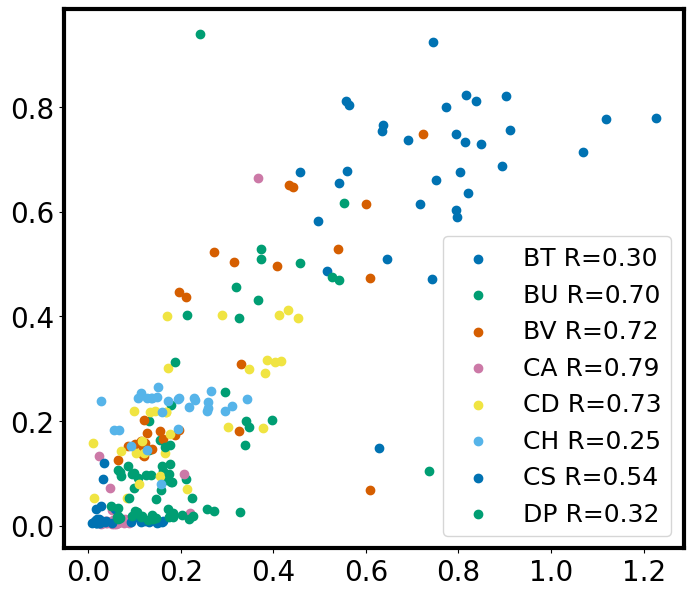

In [11]:
true = kfold_df['True'].values
pred = kfold_df['Pred'].values
stdv = kfold_df['Stdv'].values
spcs = kfold_df['Spcs'].values

for i,sp in enumerate(np.unique(spcs)):
    sp_inds = spcs == sp
    inds_pos = true[sp_inds] > 0
    
    R = linregress(true[sp_inds][inds_pos], pred[sp_inds][inds_pos]).rvalue
    plt.scatter(true[sp_inds][inds_pos], pred[sp_inds][inds_pos], c=f"C{i}", label=sp + " R={:.2f}".format(R))
plt.legend(loc="lower right")
# plt.ylim([0, 1.])
plt.show()